# ATSC-411 - SYNOPTIC METEOROLOGY | LAB 3

### QG-Omega: Geostrophic Adjustment and the Jet Streak Circulation

----- 

## IMPORT PACKAGES 
Run this cell to import Python code packages that will help us get the data, process the data, conduct math operations, and build some maps.

In [1]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np

----- 

## READ DATA 
Read in data from idealized-jet-data.nc

In [2]:
nc = Dataset('idealized-jet-data.nc','r')

x = nc.variables['x'][:]
y = nc.variables['y'][:]
p = nc.variables['p'][:]
u_wind = nc.variables['u_wind'][:]

nc.close()

----- 

## PLOT THE JET 

We'll plot the jet from above (x-y view) and a N-S cross section (y-P view).

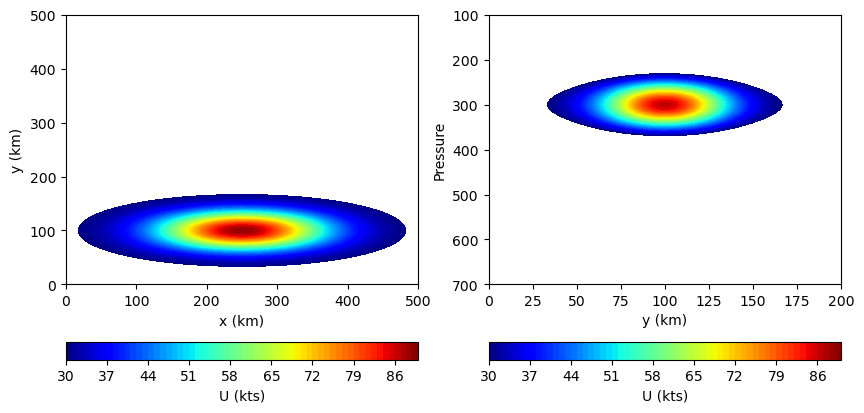

In [3]:
fig = plt.figure(figsize=(10,5), dpi=100)

#plot x-y view at z-index 65 
z_ind = 65
ax1 = fig.add_subplot(1,2,1)
ct1 = ax1.contourf(x[:,:,z_ind]/1000,y[:,:,z_ind]/1000,u_wind[:,:,z_ind],levels=np.arange(30,91),cmap='jet')
plt.colorbar(ct1,label='U (kts)',orientation='horizontal')
ax1.set_xlabel('x (km)')
ax1.set_ylabel('y (km)')
ax1.set_ylim([0,500])

#plot y-z view at x-index 55
x_ind = 55
ax2 = fig.add_subplot(1,2,2)
ct2 = ax2.contourf(y[:,x_ind,:]/1000,p[:,x_ind,:],u_wind[:,x_ind,:],levels=np.arange(30,91),cmap='jet')
plt.colorbar(ct2,label='U (kts)',orientation='horizontal')
ax2.set_xlabel('y (km)')
ax2.set_ylabel('Pressure')
ax2.set_ylim([700,100])

plt.show()

# Calculate QG-omega

$$
(\nabla_p^2 + \frac{f_0^2}{\sigma}\frac{\partial^2}{\partial p^2}) \omega = -\frac{f_0}{\sigma}\frac{\partial}{\partial p}[-\vec{v_g}\cdot\nabla_p(\zeta_g+f)]-\frac{R}{\sigma p}\nabla_p^2[-\vec{v_g}\cdot\nabla_p T]
$$

Thankfully, since we have no temperature data, we can ignore the thermal advection term.  We can also ignore the Coriolis term.  

Instead of finding actual magnitudes, let's simplify the QG-omega equation to:

$$
-\omega \propto  -\frac{\partial}{\partial p}[-\vec{v_g}\cdot\nabla_p\zeta_g]
$$

### First, calculate vorticity:
$$
\zeta_g = \frac{\partial v_g}{\partial x} - \frac{\partial u_g}{\partial y}
$$

Since there is no N-S wind:
$$
\zeta_g = - \frac{\partial u_g}{\partial y}
$$


In [4]:
#find the x, y, and p step size:
dx = x[0,1,0]-x[0,0,0]
dy = y[1,0,0]-y[0,0,0]
dp = (p[0,0,1]-p[0,0,0])*100 #hPa to Pa

#to calculate the gradient, you can use the np.gradient function
#to ensure that we are just examining the y-gradient, make sure to 
#set axis=0 in the function

du_dy = np.gradient(u_wind,axis=0)/dy
vort = -1 * du_dy


### Plot Vorticity
Let's plot the vorticity from above to verify that it makes sense.

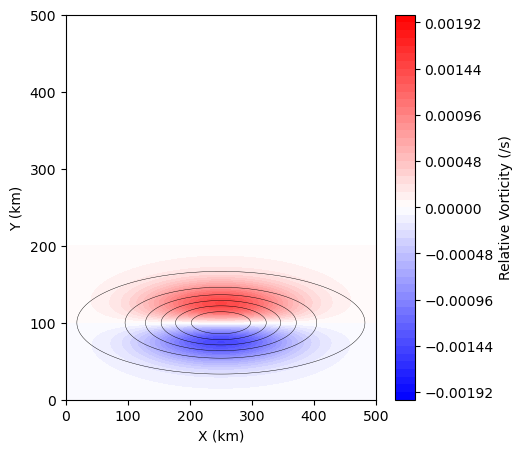

In [5]:
#plot the vorticity
fig = plt.figure(figsize=(5,5),dpi=100)
ax = fig.add_subplot(1,1,1)
ct = ax.contourf(x[:,:,z_ind]/1000,y[:,:,z_ind]/1000,vort[:,:,z_ind],levels=np.linspace(-0.002,0.002,51),cmap='bwr')
plt.colorbar(ct,label='Relative Vorticity (/s)')
ct2 = ax.contour(x[:,:,z_ind]/1000,y[:,:,z_ind]/1000,u_wind[:,:,z_ind],colors='k',levels=np.arange(10,90,10),linewidths=0.3)
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_ylim([0,500])
plt.show()

### Next, calculate vorticity advection:
$$
-\vec{v_g}\cdot\nabla_p\zeta_g
$$

Let's expand this:
$$
-\vec{v_g}\cdot(\frac{\partial\zeta_g}{\partial x}\hat{i}+\frac{\partial\zeta_g}{\partial y}\hat{j})
$$

and:
$$
-(u_g\hat{i} + v_g\hat{j})\cdot(\frac{\partial\zeta_g}{\partial x}\hat{i}+\frac{\partial\zeta_g}{\partial y}\hat{j})
$$

Since there is no N-S wind, this can be simplified to:
$$
-u_g\cdot\frac{\partial\zeta_g}{\partial x}
$$

To do this, we first need to find the horizontal gradient in vorticity, then multiply it by the u-wind.


In [14]:
#again, use np.gradient
#but this time use axis=1 since we want the x-derivative
vort_grad = np.gradient(vort,axis=1)/dx

#u*gradient of vort
vort_adv = -1 * vort_grad * u_wind

### Plot Vorticity Advection

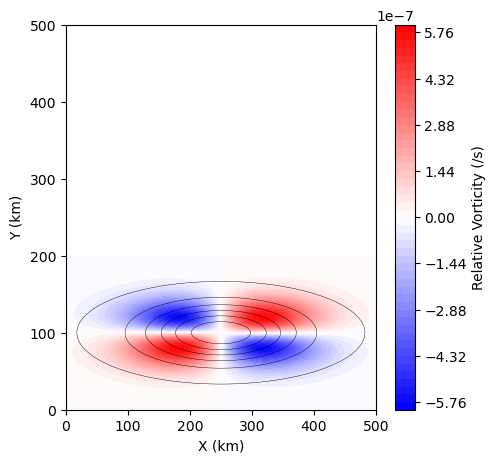

In [15]:
fig = plt.figure(figsize=(5,5),dpi=100)
ax = fig.add_subplot(1,1,1)
ct = ax.contourf(x[:,:,z_ind]/1000,y[:,:,z_ind]/1000,vort_adv[:,:,z_ind],levels=np.linspace(-6E-7,6E-7,51),cmap='bwr')
plt.colorbar(ct,label='Relative Vorticity (/s)')
ct2 = ax.contour(x[:,:,z_ind]/1000,y[:,:,z_ind]/1000,u_wind[:,:,z_ind],colors='k',levels=np.arange(10,90,10),linewidths=0.3)
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_ylim([0,500])
plt.show()

Finally, we can calculate the vertical gradient and find omega
$$
-\omega \propto  -\frac{\partial}{\partial p}[-\vec{v_g}\cdot\nabla_p\zeta_g]
$$

In [16]:
#again, use np.gradient
#you can guess which axis=# to use 
#for a vertical gradient
dva = -1 * np.gradient(vort_adv,axis=2)/dp
omega = -1 * dva

### Plot Omega

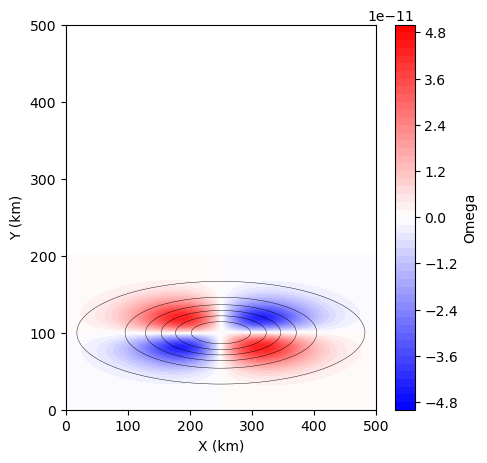

In [17]:
fig = plt.figure(figsize=(5,5),dpi=100)
ax = fig.add_subplot(1,1,1)
ct = ax.contourf(x[:,:,z_ind]/1000,y[:,:,z_ind]/1000,omega[:,:,z_ind],levels=np.linspace(-5E-11,5E-11,51),cmap='bwr')
plt.colorbar(ct,label='Omega')
ct2 = ax.contour(x[:,:,z_ind]/1000,y[:,:,z_ind]/1000,u_wind[:,:,z_ind],colors='k',levels=np.arange(10,90,10),linewidths=0.3)
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_ylim([0,500])
plt.show()

# Plot Cross Section of Omega in the Entrance & Exit Regions

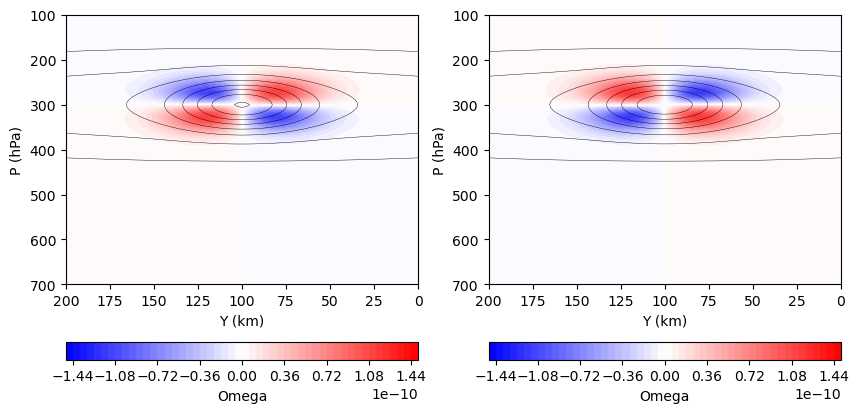

In [18]:
entrance_ind = 40
exit_ind = 60

fig = plt.figure(figsize=(10,5),dpi=100)
ax1 = fig.add_subplot(1,2,1)
ct = ax1.contourf(y[:,entrance_ind,:]/1000,p[:,entrance_ind,:],omega[:,entrance_ind,:],levels=np.linspace(-1.5E-10,1.5E-10,51),cmap='bwr')
plt.colorbar(ct,label='Omega',orientation='horizontal')
ct2 = ax1.contour(y[:,entrance_ind,]/1000,p[:,entrance_ind,:],u_wind[:,entrance_ind,:],colors='k',levels=np.arange(10,90,10),linewidths=0.3)
ax1.set_xlabel('Y (km)')
ax1.set_ylabel('P (hPa)')
ax1.set_ylim([700,100])
ax1.set_xlim([200,0])

ax2 = fig.add_subplot(1,2,2)
ct = ax2.contourf(y[:,exit_ind,:]/1000,p[:,exit_ind,:],omega[:,exit_ind,:],levels=np.linspace(-1.5E-10,1.5E-10,51),cmap='bwr')
plt.colorbar(ct,label='Omega',orientation='horizontal')
ct2 = ax2.contour(y[:,exit_ind,]/1000,p[:,exit_ind,:],u_wind[:,exit_ind,:],colors='k',levels=np.arange(10,90,10),linewidths=0.3)
ax2.set_xlabel('Y (km)')
ax2.set_ylabel('P (hPa)')
ax2.set_ylim([700,100])
ax2.set_xlim([200,0])
plt.show()

# LAB QUESTIONS

#### 1) Given an W-E oriented jet streak in the westerlies, where would you expect positive and negative vorticity?  Does this match the plot you created?

#### 2) Since there are only westerly winds, does the plot of vorticity advection match what you expect?  Where is the cyclonic (positive) and anticyclonic (negative) vorticity advection?

#### 3) Does the vertical wind direction cross-section match what you would expect by applying the differential vorticity advection term?  Make sure to explain all 4 velocity regions in both the entrance and exit regions.

#### 4) Sketch the circular, transverse circulations around the jet streak entrance and exit regions.
